### Implementing a REAL NVP model for toy dataset

Michael Albergo

In [99]:

%matplotlib inline
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import os
import datetime
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
#import palettable
import seaborn as sns

We will try to learn the invertible mapping between a 2D gaussian and an arbitrary pretty shape in 2D space. An overview of this optimization process, and how the unique architecture of these coupling layers is put to use, is [provided here](https://machine19.github.io/machine19.github.io/Blogs/Albergo_GenModels/GenModels.html). We define this input dimension below, and say we will use 10 coupling layers to perform our modeling. Each of these coupling layers has two neural networks, $s_i$ and $t_i$, associated with it that we will optimize through minimzing the negative log likelihood of the data. 

In [100]:

input_size = 2 # dimension
n_layers = 10 # how many coupling layers
K = 3 # number of curls in fake data

Below is how we generate some pretty 2D distributions to model.

tensor(-0.9672, dtype=torch.float64)


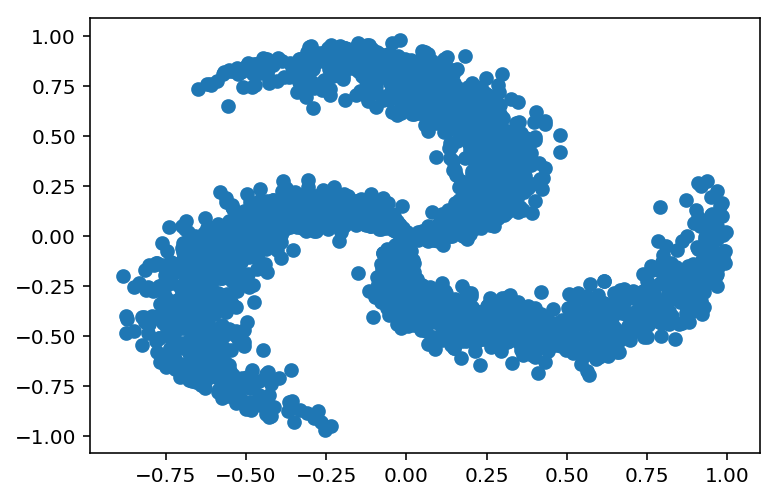

In [102]:
def real_sample(N = 100, K = 3):
    N_train = N*K # total number of points in the training set
    x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
    y_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)

    mag_noise = 0.2 # controls how much noise gets added to the data
    dTheta    = 2   # difference in theta in each branch

    ### Data generation: ###
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.01,1,N) # radius
        t = np.linspace(j*(2*np.pi)/K,j*(2*np.pi)/K + dTheta,N) + np.random.randn(N)*mag_noise # theta
        x_train[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        
    return torch.from_numpy(x_train).double()

test = real_sample(N=1000)
print(test.min())
plt.scatter(test[:, 0], test[:, 1], s=40)
plt.show()

We want to learn this above distribution $p(\mathbf{x})$, and want to do so by relating it via a change of variables to a tractable distribution which we can easily perform inference on, such as a Gaussian, via:

$$
				p(\mathbf{x}) = p_z(f(\mathbf{x}))\bigg\lvert \det \frac{\partial f(x)}{\partial x^T}\bigg \lvert
$$
					
Note: because we assume $\mathbf{z}$ is multi-dimensional, we label $\frac{\partial f(x)}{\partial x^T}$ as the Jacobian of the $f$. This seems simple enough, so there must be a catch. And that catch is in coming up with a way to represent a highly flexible and complicated function$f$ that one can easily invert. By splitting the learning of our function into a number of "coupling layers" we can ensure the function is easily invertible and its Jacobian is not intractable to compute. We define each coupling layer as a transformation of the form: 
$$\mathbf{y} =    \left\{ \begin{array}{ll} y_{1:d} = x_{1:d} \\ y_{d+1:D} = x_{d+1:D} \odot \exp{(s(x_{1:d})) + t(x_{1:d})}  \end{array} \right. $$ 
whose inverse is given by the form: $$\big\Downarrow \\ \mathbf{y}^{-1} =  \{ \begin{array}{ll} x_{1:d} = y_{1:d} \\ x_{d+1:D} =(y_{d+1:D} - t(y_{1:d})) \odot \exp{(-s(y_{1:d}))}   \end{array}$$
					
In this process the centerpiece is the set of neural networks $\{\mathbf{s}\}$ and $\{\mathbf{t}\}$, one of each for each coupling layer, who help make our invertible functions complex and expressive. When an instance of our "Coupling" class is instantiated below, we make it such that a random permutation of the dimensions of our data (just 2 here) are chosen as the splitting criteria for $\mathbf{x}_{1:d}$ and $\mathbf{x}_{d+1:D}$. For each subsequent coupling layer, the indices of these variables are swapped so that the other dimension can get the same transformation treatment (remember, as per the function above, we leave half the dimensions of our data unchanged during each coupling). This way each slice of our input gets subjected to the same number of nonlinear transformations. Below is the implementation of the "Coupling" class through which such transformations are implemented. The log of the determinant of the Jacobian is computed at each pass through `func(self, x, i)`, which defines the forward pass of a coupling layer. The index `i` is used to tell `func` which dimensions of the input should be manipulated next (via a modulo 2 in the masking function) as well as that the $i^{th}$ pair of neural networks ($s_i, t_i$) should be used in the calculation. Because of our useful choice of affine coupling layer, computing the log of the determinant of the Jacobian amounts to taking the sum of the $s_i(x_{1:d}$ terms. See blog post linked at the top for details. 

When you want to sample from your learned (or learning) distribution, you feed in some batch of 2D Gaussian noise in the `sample(self, batchSize)` function and traverse backwards through the inverse manipulations $y^{-1}$ as defined above. Note that the set of networks $\{\mathbf{s}\}$ and $\{\mathbf{t}\}$ should now be indexed over in reverse order. 
					

In [103]:
class Coupling(nn.Module):
    def __init__(self, input_size):
        super(Coupling, self).__init__()
        
        self.input_size = input_size
        self.n_layers = n_layers
        
        # set up networks
        self.s = torch.nn.ModuleList([torch.nn.Sequential(
                            torch.nn.Linear(input_size // 2, 35),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(35, 35),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(35, input_size // 2)) for i in range(n_layers)])
        self.t = torch.nn.ModuleList([torch.nn.Sequential(
                            torch.nn.Linear(input_size // 2, 35),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(35, 35),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(35, input_size // 2),
                            torch.nn.Tanh()) for i in range(n_layers)])
        
        # set up index splitting
        self.perm = torch.randperm(input_size)
        
        # set up prior
        self.prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
        
        # how many dimensions does each splitting get
        self.k = self.input_size // 2
        self.idx1 =  self.perm[:self.k]
        self.idx2 =  self.perm[self.k:]
        self.logjacdets = []
    
    def mask(self, x, perm, i ):
        
        k = x.size(1) // 2
        if i % 2 == 0:
            x1 = x[:,self.idx1]
            x2 = x[:,self.idx2]
        else:
            x1 = x[:,self.idx2]
            x2 = x[:,self.idx1]

        return x1, x2, self.idx1, self.idx2
    
    # reorganized permuted indices
    def re_sort(self, z1,z2, id1,id2):
        ids = torch.argsort(torch.cat((id1,id2),0))
        re_z = torch.cat((z1,z2), dim=1)
        z = re_z[:,ids]
        
        return z
    
    def logjacobian_det(self,x1,i):
        logdetjac = (torch.sum(self.s[i](x1), dim=1))
        return logdetjac

    # forward pass for ith coupling layer
    def func(self, x, i):
        #logjacdets = []
        x1, x2, id1, id2 = self.mask(x, self.perm, i )
        y1 = x1
        y2 = self.t[i](x1) + x2*torch.exp(self.s[i](x1))
        logjacdet = self.logjacobian_det(y1, i)
        self.logjacdets.append(logjacdet)
        y = self.re_sort(y1,y2, id1,id2)
        return y
    
    # inverse pass for (n_layers - ith) coupling layer
    def inverse_func(self, z, i):
        z1, z2, id1, id2 = self.mask(z, self.perm, i)
        x1 = z2
        x2 = (z1 - self.t[i](z2)) *torch.exp(- self.s[i](z2))
        x = self.re_sort(x1,x2, id1,id2)
        return x
    
    
    def log_prob(self,z, logjacdets):
        return  self.prior.log_prob(z) + sum(self.logjacdets)
    
    # run model 
    def forward(self, x):
        self.logjacdets = []
        for i in range(n_layers):
            if i == 0:
                z = self.func(x, i )
            else:
                z = self.func(z, i )
        logp = self.log_prob(z, self.logjacdets)
        return z, logp
    
    def sample(self, batchSize):
        decode = self.prior.sample((batchSize,))
        #x = self.inverse_func(z)
        for i in range(0, n_layers)[::-1]:
           # print(i)
            if i == range(0, n_layers)[-1]:
                x = self.inverse_func(decode, i )
            else:
                x = self.inverse_func(x, i )
        return x
        

model = Coupling(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


We can now train our model. If the interactive code right below this doesn't work, skip it and run the block below it. You will see $f(x)$ transform into a gaussian, while $f^{-1}(z)$ transform into our structured output.

<IPython.core.display.Javascript object>


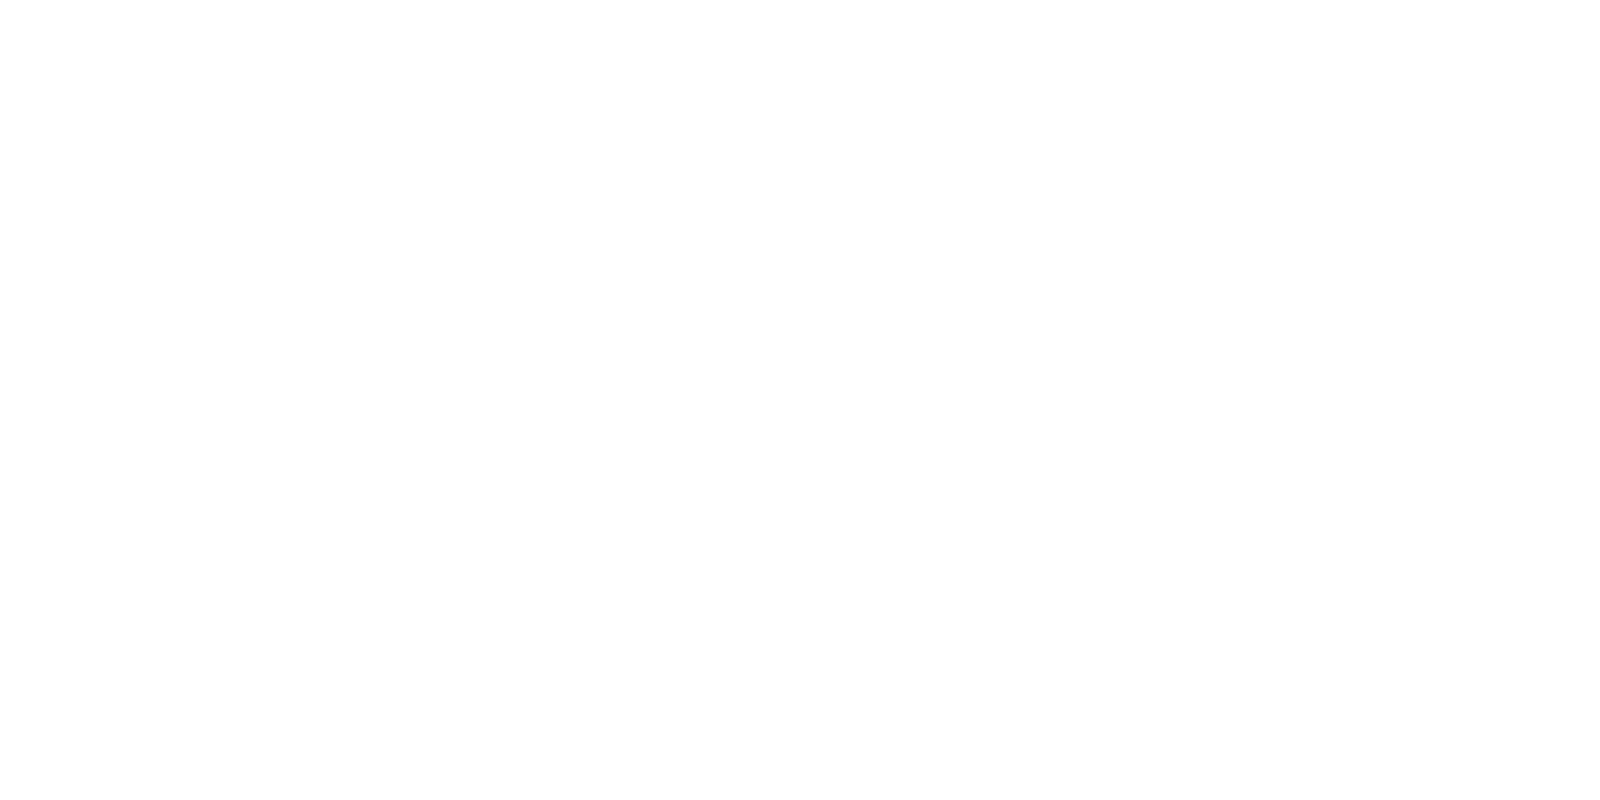

Epoch 0 ---> log loss = 2.181
Epoch 500 ---> log loss = 0.412


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


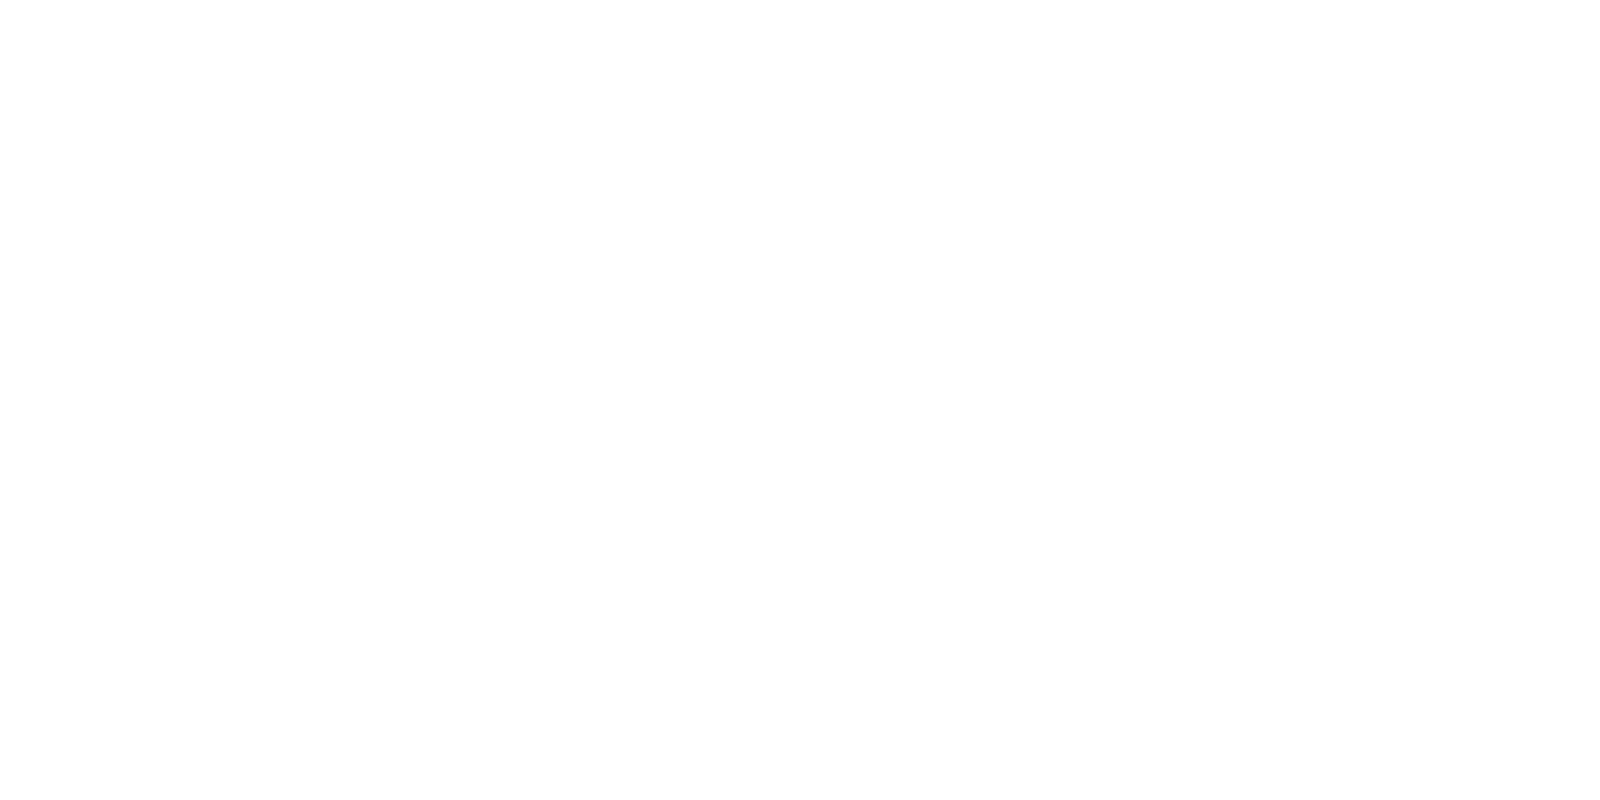

In [104]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':'tight'}
matplotlib.rcParams['figure.dpi'] = 100
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(8,4))
#plt.ion()

scatter1 = plt.scatter([], [], color='blue')
scatter2 = plt.scatter([], [], color='orange')
#ax1.set_title("f(x)")
#ax2.set_title(r"$f^{-1}(z)$")

for i in range(10000):

    sample = real_sample(N = 250, K = K)
    z, logp = model(sample.float())
    
    if i % 50 == 0:
        ax1.clear()
        ax2.clear()
        zs = model(sample.float())[0].detach().numpy()
        test_x = model.sample(400).cpu().data.numpy()
        #fig, [ax1,ax2]=plt.subplots(1,2,figsize=(8,4))
        #ax1 = fig.add_subplot(111)
        ax1.scatter(zs[:,0], zs[:,1], color = 'xkcd:blue', alpha = 0.8)
        ax1.set_title("f(x)", fontsize = 14)
        ax2.scatter(test_x[:,0],test_x[:,1], color = 'xkcd:orange', alpha = 0.8)
        ax2.set_title(r"$f^{-1}(z)$", fontsize = 14)
        fig.canvas.draw()
        
        #plt.show()
        
    loss = -logp.mean()
    
    if i % 500 == 0:
        print("Epoch %s --->" % i, 'log loss = %.3f' % loss)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    


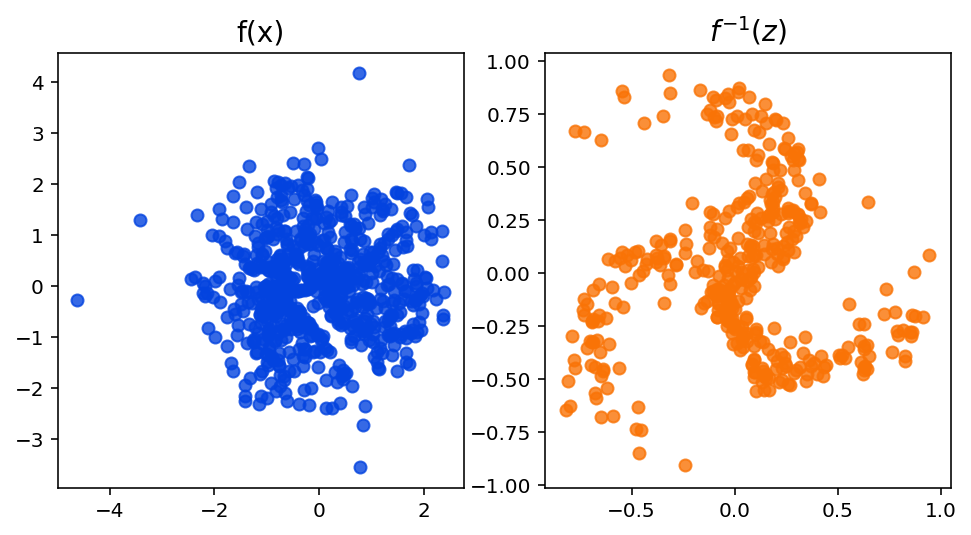

Epoch 0 ---> log loss = 0.254


KeyboardInterrupt: 

In [105]:
%matplotlib inline
for i in range(10000):

    sample = real_sample(N = 250, K = K)
    z, logp = model(sample.float())
    
    if i % 500 == 0:
        zs = model(sample.float())[0].detach().numpy()
        test_x = model.sample(400).cpu().data.numpy()
        fig, [ax1,ax2]=plt.subplots(1,2,figsize=(8,4))
        ax1.scatter(zs[:,0], zs[:,1], color = 'xkcd:blue', alpha = 0.8)
        ax1.set_title("f(x)", fontsize = 14)
        ax2.scatter(test_x[:,0],test_x[:,1], color = 'xkcd:orange', alpha = 0.8)
        ax2.set_title(r"$f^{-1}(z)$", fontsize = 14)
        plt.show()
        
    loss = -logp.mean()
    
    if i % 500 == 0:
        print("Epoch %s --->" % i, 'log loss = %.3f' % loss)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    


Text(0, 0.5, 'x2')

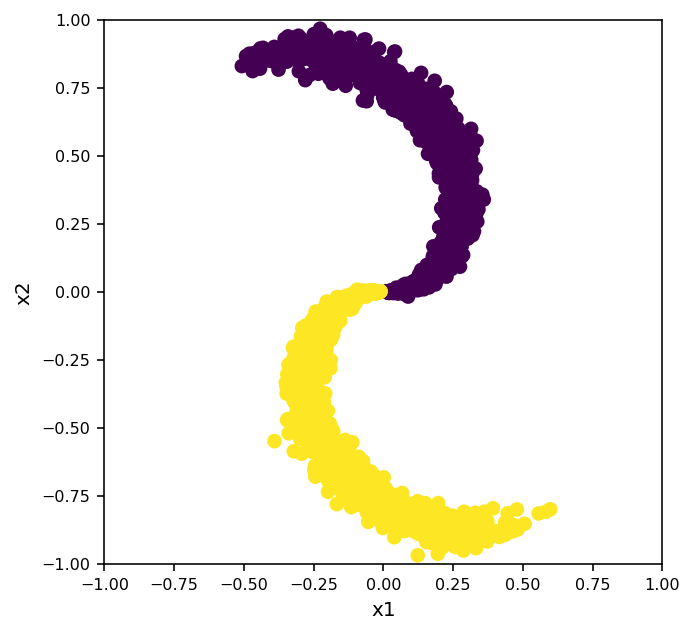

In [174]:
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

seed=1234
np.random.seed(seed)
#tf.set_random_seed(seed)

plt.ion() # turn on interactive mode (for plotting)


N = 1000 # number of points per branch
K = 2  # number of branches

N_train = N*K # total number of points in the training set
x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
y_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)

mag_noise = 0.1  # controls how much noise gets added to the data
dTheta    = 2   # difference in theta in each branch

### Data generation: ###
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.01,1,N) # radius
    t = np.linspace(j*(2*np.pi)/K,j*(2*np.pi)/K + dTheta,N) + np.random.randn(N)*mag_noise # theta
    x_train[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
    y_train[ix] = j

### Plot the data set: ###
fig = plt.figure(1, figsize=(5,5))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=40)#, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('x1')
plt.ylabel('x2')

In [29]:
test = np.arange(0,12)

In [35]:
test[-1]

11